# ResNet-18 CNN: PyTorch & CIFAR-10

End-to-end programming tutorial including:

1. Progress bar - training model
1. Train model with _early stopping criterion_
1. Learning rate scheduler
1. Compare between learning rate scheduler and early stopping criterion

[Reference](https://d2l.ai/chapter_convolutional-modern/resnet.html#fig-residual-block)

In [1]:
# Specify GPU to be used-
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES = 2

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=2


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms


from tqdm import tqdm
from tqdm import trange
import matplotlib.pyplot as plt
import numpy as np
import os

In [3]:
# Device configuration-
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"currently available device: {device}")

currently available device: cuda


In [4]:
print(f"PyTorch version: {torch.__version__}")

PyTorch version: 1.8.0


In [5]:
# Hyper-parameters-
num_epochs = 65
batch_size = 128
learning_rate = 0.01

In [6]:
# Define transformations for training and test sets-
transform_train = transforms.Compose(
    [
      transforms.RandomCrop(32, padding = 4),
      transforms.RandomHorizontalFlip(),
      transforms.ToTensor(),
      transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
     ]
     )

transform_test = transforms.Compose(
    [
      transforms.ToTensor(),
      transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
     ]
     )

In [7]:
# Load dataset-
train_dataset = torchvision.datasets.CIFAR10(
        root = './data', train = True,
        download = True, transform = transform_train
        )

test_dataset = torchvision.datasets.CIFAR10(
        root = './data', train = False,
        download = True, transform = transform_test
        )

Files already downloaded and verified
Files already downloaded and verified


In [8]:
print(f"len(train_dataset) = {len(train_dataset)} & len(test_dataset) = {len(test_dataset)}")

len(train_dataset) = 50000 & len(test_dataset) = 10000


In [9]:
# Create training and testing loaders-
train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size = batch_size,
        shuffle = True
        )

test_loader = torch.utils.data.DataLoader(
        test_dataset, batch_size = batch_size,
        shuffle = False
        )

In [10]:
print(f"len(train_loader) = {len(train_loader)} & len(test_loader) = {len(test_loader)}")

len(train_loader) = 391 & len(test_loader) = 79


In [11]:
# Sanity check-
len(train_dataset) / batch_size, len(test_dataset) / batch_size

(390.625, 78.125)

In [12]:
# Sanity check-
len(train_dataset) / batch_size, len(test_dataset) / batch_size

# Sanity check-
images, labels = next(iter(train_loader))

images.size(), labels.shape

(torch.Size([128, 3, 32, 32]), torch.Size([128]))

### Define _ResNet-18_ architecture:

In [14]:
class ResidualBlock(nn.Module):
    '''
    Residual Block within a ResNet CNN model
    '''
    def __init__(self, input_channels, num_channels, 
                 use_1x1_conv = False, strides = 1):
        # super(ResidualBlock, self).__init__()
        super().__init__()
     
        self.conv1 = nn.Conv2d(
            in_channels = input_channels, out_channels = num_channels,
            kernel_size = 3, padding = 1, stride = strides,
            bias = False
            )
        self.conv2 = nn.Conv2d(
            in_channels = num_channels, out_channels = num_channels,
            kernel_size = 3, padding = 1, stride = 1,
            bias = False
            )
        
        if use_1x1_conv:
            self.conv3 = nn.Conv2d(
                in_channels = input_channels, out_channels = num_channels,
                kernel_size = 1, stride = strides
                )
        else:
            self.conv3 = None
        
        self.bn1 = nn.BatchNorm2d(num_features = num_channels)
        self.bn2 = nn.BatchNorm2d(num_features = num_channels)
        self.relu = nn.ReLU(inplace = True)

        self.initialize_weights()
        
    
    def forward(self, X):
        Y = F.relu(self.bn1(self.conv1(X)))
        Y = self.bn2(self.conv2(Y))
        
        if self.conv3:
            X = self.conv3(X)
            # print(f"X.shape due to 1x1: {X.shape} & Y.shape = {Y.shape}")
        else:
            # print(f"X.shape without 1x1: {X.shape} & Y.shape = {Y.shape}")
            pass
        
        Y += X
        return F.relu(Y)
    
    
    def shape_computation(self, X):
        Y = self.conv1(X)
        print(f"self.conv1(X).shape: {Y.shape}")
        Y = self.conv2(Y)
        print(f"self.conv2(X).shape: {Y.shape}")
        
        if self.conv3:
            h = self.conv3(X)
            print(f"self.conv3(X).shape: {h.shape}")
    

    def initialize_weights(self):
        for m in self.modules():
            # print(m)
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_uniform_(m.weight)

                '''
                # Do not initialize bias (due to batchnorm)-
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
                '''
            
            elif isinstance(m, nn.BatchNorm2d):
                # Standard initialization for batch normalization-
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

            elif isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight)
                nn.init.constant_(m.bias, 0)

In [23]:
b0 = nn.Sequential(
    nn.Conv2d(in_channels = 3, out_channels = 64, kernel_size = 3, stride = 1, padding = 1),
    nn.BatchNorm2d(num_features = 64),
    nn.ReLU()
)

In [18]:
# Sanity check-
b0(images).shape

torch.Size([128, 64, 32, 32])

In [19]:
# del b0

In [20]:
def create_resnet_block(input_filters, output_filters, num_residuals, first_block = False):
    # Python list to hold the created ResNet blocks-
    resnet_blk = []
    
    for i in range(num_residuals):
        if i == 0 and first_block:
            resnet_blk.append(ResidualBlock(input_channels = input_filters, num_channels = output_filters, use_1x1_conv = True, strides = 2))
        else:
            resnet_blk.append(ResidualBlock(input_channels = output_filters, num_channels = output_filters, use_1x1_conv = False, strides = 1))
    
    return resnet_blk

In [24]:
b1 = nn.Sequential(*create_resnet_block(input_filters = 64, output_filters = 64, num_residuals = 2, first_block = True))
# b2 = nn.Sequential(*create_resnet_block(input_filters = 64, output_filters = 64, num_residuals = 2))
b3 = nn.Sequential(*create_resnet_block(input_filters = 64, output_filters = 128, num_residuals = 2, first_block = True))
# b4 = nn.Sequential(*create_resnet_block(input_filters = 128, output_filters = 128, num_residuals = 2))
b5 = nn.Sequential(*create_resnet_block(input_filters = 128, output_filters = 256, num_residuals = 2, first_block = True))
# b6 = nn.Sequential(*create_resnet_block(input_filters = 256, output_filters = 256, num_residuals = 2))
b7 = nn.Sequential(*create_resnet_block(input_filters = 256, output_filters = 512, num_residuals = 2, first_block = True))
# b8 = nn.Sequential(*create_resnet_block(input_filters = 512, output_filters = 512, num_residuals = 2))

In [25]:
# Initialize ResNet-18 model-
model = nn.Sequential(
    # b0, b1, b2, b3, b4, b5, b6, b7, b8,
    b0, b1, b3, b5, b7,
    nn.AdaptiveAvgPool2d(output_size = (1, 1)),
    nn.Flatten(),
    nn.Linear(in_features = 512, out_features = 10))

In [26]:
# Sanity check-
model(images).shape

torch.Size([128, 10])

In [27]:
# Place model on GPU-
model.to(device)

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (1): Sequential(
    (0): ResidualBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (conv3): Conv2d(64, 64, kernel_size=(1, 1), stride=(2, 2))
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
    )
    (1): ResidualBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, aff

In [28]:
# Count number of layer-wise parameters and total parameters-
tot_params = 0
for param in model.parameters():
    print(f"layer.shape = {param.shape} has {param.nelement()} parameters")
    tot_params += param.nelement()

layer.shape = torch.Size([64, 3, 3, 3]) has 1728 parameters
layer.shape = torch.Size([64]) has 64 parameters
layer.shape = torch.Size([64]) has 64 parameters
layer.shape = torch.Size([64]) has 64 parameters
layer.shape = torch.Size([64, 64, 3, 3]) has 36864 parameters
layer.shape = torch.Size([64, 64, 3, 3]) has 36864 parameters
layer.shape = torch.Size([64, 64, 1, 1]) has 4096 parameters
layer.shape = torch.Size([64]) has 64 parameters
layer.shape = torch.Size([64]) has 64 parameters
layer.shape = torch.Size([64]) has 64 parameters
layer.shape = torch.Size([64]) has 64 parameters
layer.shape = torch.Size([64]) has 64 parameters
layer.shape = torch.Size([64, 64, 3, 3]) has 36864 parameters
layer.shape = torch.Size([64, 64, 3, 3]) has 36864 parameters
layer.shape = torch.Size([64]) has 64 parameters
layer.shape = torch.Size([64]) has 64 parameters
layer.shape = torch.Size([64]) has 64 parameters
layer.shape = torch.Size([64]) has 64 parameters
layer.shape = torch.Size([128, 64, 3, 3]) h

In [29]:
print(f"Total number of parameters in VGG-18 CNN = {tot_params}")

Total number of parameters in VGG-18 CNN = 11177290


In [ ]:
'''
# Print layer names-
for layer in model.state_dict().keys():
    print(f"{layer} has dimension = {model.state_dict()[layer].shape}")
'''

In [30]:
# Save random initial weights-
torch.save(model.state_dict(), 'ResNet18_random_weights.pth')

In [21]:
# Load randomly initialised weights-
# model.load_state_dict(torch.load('ResNet18_random_weights.pth'))

<All keys matched successfully>

In [31]:
# Define loss function and optimizer-
loss = nn.CrossEntropyLoss()

# optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
optimizer = torch.optim.SGD(model.parameters(), lr = 0.01, momentum = 0.9, weight_decay = 5e-4)

In [32]:
def train_step(model, train_loader):
    running_loss = 0.0
    running_corrects = 0.0

    for batch, (images, labels) in enumerate(train_loader):
        # Attempt to push to GPU if available
        images = images.to(device)
        labels = labels.to(device)

        # print(f"batch # = {batch}")

        model.train()

        # Forward pass-
        outputs = model(images)

        # Compute loss-
        J = loss(outputs, labels)

        # Backward pass-
        optimizer.zero_grad()   # empty accumulated gradients

        J.backward()    # perform backpropagation

        # Updates parameters-
        optimizer.step()
        
        # Compute model's performance statistics-
        running_loss += J.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        running_corrects += torch.sum(predicted == labels.data)

        '''
        # Print information every 100 steps-
        if (batch + 1) % 100 == 0:
            print(f"epoch {epoch + 1}/{num_epochs}, step {batch + 1}/{num_training_steps}, loss = {J.item():.4f}")
        '''

    epoch_loss = running_loss / len(train_dataset)
    epoch_acc = (running_corrects.double() / len(train_dataset)) * 100
    
    return epoch_loss, epoch_acc.cpu().numpy()
    


In [33]:
def train_model_progress(model, train_loader):
    '''
    Function to perform one epoch of training by using 'train_loader'.
    Returns loss and number of correct predictions for this epoch.
    '''
    running_loss = 0.0
    running_corrects = 0.0
    
    model.train()
    
    with tqdm(train_loader, unit = 'batch') as tepoch:
        for images, labels in tepoch:
            tepoch.set_description(f"Training: ")
            
            images = images.to(device)
            labels = labels.to(device)
            
            # Get model predictions-
            outputs = model(images)
            
            # Compute loss-
            J = loss(outputs, labels)
            
            # Empty accumulated gradients-
            optimizer.zero_grad()
            
            # Perform backprop-
            J.backward()
            
            # Update parameters-
            optimizer.step()
            
            # Compute model's performance statistics-
            running_loss += J.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            running_corrects += torch.sum(predicted == labels.data)
            
            tepoch.set_postfix(
                loss = running_loss / len(train_dataset),
                accuracy = (running_corrects.double().cpu().numpy() / len(train_dataset)) * 100
            )
            
    
    train_loss = running_loss / len(train_dataset)
    train_acc = (running_corrects.double() / len(train_dataset)) * 100
    

    # return running_loss, running_corrects
    return train_loss, train_acc.cpu().numpy()
    


In [34]:
def validate_step(model, test_loader):
    total, correct = 0, 0
    running_loss_val = 0.0

    with torch.no_grad():
        for images, labels in test_loader:

            # Place features (images) and targets (labels) to GPU-
            images = images.to(device)
            labels = labels.to(device)

            # Set model to evaluation mode-
            model.eval()
    
            # Make predictions using trained model-
            outputs = model(images)
            _, y_pred = torch.max(outputs, 1)

            # Compute validation loss-
            J_val = loss(outputs, labels)

            running_loss_val += J_val.item() * labels.size(0)
    
            # Total number of labels-
            total += labels.size(0)

            # Total number of correct predictions-
            correct += (y_pred == labels).sum()

    epoch_val_loss = running_loss_val / len(test_dataset)
    val_acc = 100 * (correct / total)

    return epoch_val_loss, val_acc.cpu().numpy()


In [35]:
def test_model_progress(model, test_loader):
    total = 0.0
    correct = 0.0
    running_loss_val = 0.0

    with torch.no_grad():
        with tqdm(test_loader, unit = 'batch') as tepoch:
            for images, labels in tepoch:
                tepoch.set_description(f"Validation: ")
                
                images = images.to(device)
                labels = labels.to(device)
                
                # Set model to evaluation mode-
                model.eval()
            
                # Predict using trained model-
                outputs = model(images)
                _, y_pred = torch.max(outputs, 1)
                
                # Compute validation loss-
                J_val = loss(outputs, labels)
                
                running_loss_val += J_val.item() * labels.size(0)
    
                # Total number of labels-
                total += labels.size(0)

                # Total number of correct predictions-
                correct += (y_pred == labels).sum()
                
                tepoch.set_postfix(
                    val_loss = running_loss_val / len(test_dataset),
                    val_acc = 100 * (correct.cpu().numpy() / total)
                )
            
        
    # return (running_loss_val, correct, total)
    val_loss = running_loss_val / len(test_dataset)
    val_acc = (correct / total) * 100

    return val_loss, val_acc.cpu().numpy()


In [33]:
# Sanity check-
train_loss, train_acc = train_model_progress(model, train_loader)

Training: : 100%|██████████| 391/391 [04:08<00:00,  1.57batch/s, accuracy=45.5, loss=1.47]


In [34]:
# Sanity check-
val_loss, val_acc = test_model_progress(model, test_loader)

Validation: : 100%|██████████| 79/79 [00:08<00:00,  9.06batch/s, val_acc=56.6, val_loss=1.21]


### Train model _without_ learning rate scheduler, using early-stopping criterion

In [36]:
# Initialize parameters for Early Stopping manual implementation-
best_val_loss = 100
loc_patience = 0

In [37]:
# User input parameters for Early Stopping in manual implementation-
minimum_delta = 0.001
patience = 3

In [38]:
training_history = {}

In [39]:
for epoch in range(num_epochs):

    if loc_patience >= patience:
        print("\n'EarlyStopping' called!\n")
        break

    train_loss, train_acc = train_model_progress(model, train_loader)
    val_loss, val_acc = test_model_progress(model, test_loader)
    
    print(f"\nepoch: {epoch + 1} training loss = {train_loss:.4f}, "
          f"training accuracy = {train_acc:.2f}%, val_loss = {val_loss:.4f}"
          f", val_accuracy = {val_acc:.2f}% & "
          f"LR = {optimizer.param_groups[0]['lr']:.4f}\n")
    
    training_history[epoch + 1] = {
        'loss': train_loss, 'acc': train_acc,
        'val_loss': val_loss, 'val_acc': val_acc,
        'lr': optimizer.param_groups[0]['lr']
    }

    '''
    # Save best weights achieved until now-
    if (val_loss < best_val_loss):    
        # update 'best_val_loss' variable to lowest loss encountered so far-
        best_val_loss = val_loss

        print(f"Saving model with lowest val_loss = {val_loss:.4f}\n")
        
        # Save trained model with 'best' validation accuracy-
        torch.save(model.state_dict(), "VGG18_best_model.pth")
    '''

    # Code for manual Early Stopping:
    # if np.abs(val_loss < best_val_loss) >= minimum_delta:
    if (val_loss < best_val_loss) and \
    (np.abs(val_loss - best_val_loss) >= minimum_delta):

        # update 'best_val_loss' variable to lowest loss encountered so far-
        best_val_loss = val_loss
        
        # reset 'loc_patience' variable-
        loc_patience = 0

        print(f"Saving model with lowest val_loss = {val_loss:.4f}\n")
        
        # Save trained model with 'best' validation accuracy-
        torch.save(model.state_dict(), "ResNet18_best_model.pth")
        
    else:  # there is no improvement in monitored metric 'val_loss'
        loc_patience += 1  # number of epochs without any improvement
    

Validation: : 100%|██████████| 79/79 [00:03<00:00, 21.66batch/s, val_acc=47.1, val_loss=1.45] 



epoch: 1 training loss = 1.6489, training accuracy = 39.89%, val_loss = 1.4484, val_accuracy = 47.06% & LR = 0.0100

Saving model with lowest val_loss = 1.4484



Validation: : 100%|██████████| 79/79 [00:04<00:00, 18.51batch/s, val_acc=58.7, val_loss=1.14] 



epoch: 2 training loss = 1.3048, training accuracy = 52.70%, val_loss = 1.1408, val_accuracy = 58.66% & LR = 0.0100

Saving model with lowest val_loss = 1.1408



Validation: : 100%|██████████| 79/79 [00:04<00:00, 18.98batch/s, val_acc=63.1, val_loss=1.04] 



epoch: 3 training loss = 1.1228, training accuracy = 59.56%, val_loss = 1.0375, val_accuracy = 63.10% & LR = 0.0100

Saving model with lowest val_loss = 1.0375



Validation: : 100%|██████████| 79/79 [00:04<00:00, 18.21batch/s, val_acc=67.2, val_loss=0.915]



epoch: 4 training loss = 0.9990, training accuracy = 64.30%, val_loss = 0.9146, val_accuracy = 67.20% & LR = 0.0100

Saving model with lowest val_loss = 0.9146



Validation: : 100%|██████████| 79/79 [00:03<00:00, 19.80batch/s, val_acc=67.7, val_loss=0.938]



epoch: 5 training loss = 0.8974, training accuracy = 68.08%, val_loss = 0.9376, val_accuracy = 67.66% & LR = 0.0100



Validation: : 100%|██████████| 79/79 [00:04<00:00, 18.46batch/s, val_acc=69.1, val_loss=0.914]



epoch: 6 training loss = 0.8130, training accuracy = 71.28%, val_loss = 0.9141, val_accuracy = 69.07% & LR = 0.0100



Validation: : 100%|██████████| 79/79 [00:04<00:00, 18.20batch/s, val_acc=73.8, val_loss=0.743] 



epoch: 7 training loss = 0.7435, training accuracy = 73.80%, val_loss = 0.7426, val_accuracy = 73.75% & LR = 0.0100

Saving model with lowest val_loss = 0.7426



Validation: : 100%|██████████| 79/79 [00:04<00:00, 18.78batch/s, val_acc=75.6, val_loss=0.716]



epoch: 8 training loss = 0.6786, training accuracy = 76.29%, val_loss = 0.7160, val_accuracy = 75.63% & LR = 0.0100

Saving model with lowest val_loss = 0.7160



Validation: : 100%|██████████| 79/79 [00:03<00:00, 23.78batch/s, val_acc=77, val_loss=0.654]   



epoch: 9 training loss = 0.6330, training accuracy = 77.76%, val_loss = 0.6544, val_accuracy = 76.97% & LR = 0.0100

Saving model with lowest val_loss = 0.6544



Validation: : 100%|██████████| 79/79 [00:03<00:00, 19.97batch/s, val_acc=77.5, val_loss=0.65]  



epoch: 10 training loss = 0.5870, training accuracy = 79.41%, val_loss = 0.6496, val_accuracy = 77.46% & LR = 0.0100

Saving model with lowest val_loss = 0.6496



Validation: : 100%|██████████| 79/79 [00:04<00:00, 18.21batch/s, val_acc=79.2, val_loss=0.608] 



epoch: 11 training loss = 0.5565, training accuracy = 80.41%, val_loss = 0.6078, val_accuracy = 79.21% & LR = 0.0100

Saving model with lowest val_loss = 0.6078



Validation: : 100%|██████████| 79/79 [00:04<00:00, 18.56batch/s, val_acc=79.8, val_loss=0.591] 



epoch: 12 training loss = 0.5296, training accuracy = 81.57%, val_loss = 0.5910, val_accuracy = 79.84% & LR = 0.0100

Saving model with lowest val_loss = 0.5910



Validation: : 100%|██████████| 79/79 [00:03<00:00, 20.73batch/s, val_acc=80.4, val_loss=0.57]  



epoch: 13 training loss = 0.4943, training accuracy = 82.88%, val_loss = 0.5702, val_accuracy = 80.44% & LR = 0.0100

Saving model with lowest val_loss = 0.5702



Validation: : 100%|██████████| 79/79 [00:04<00:00, 19.23batch/s, val_acc=80.4, val_loss=0.59]  



epoch: 14 training loss = 0.4763, training accuracy = 83.51%, val_loss = 0.5901, val_accuracy = 80.39% & LR = 0.0100



Validation: : 100%|██████████| 79/79 [00:04<00:00, 18.30batch/s, val_acc=83, val_loss=0.501]   



epoch: 15 training loss = 0.4526, training accuracy = 84.19%, val_loss = 0.5012, val_accuracy = 83.05% & LR = 0.0100

Saving model with lowest val_loss = 0.5012



Validation: : 100%|██████████| 79/79 [00:04<00:00, 18.29batch/s, val_acc=82.8, val_loss=0.517] 



epoch: 16 training loss = 0.4263, training accuracy = 85.02%, val_loss = 0.5173, val_accuracy = 82.78% & LR = 0.0100



Validation: : 100%|██████████| 79/79 [00:04<00:00, 19.58batch/s, val_acc=83.1, val_loss=0.504] 



epoch: 17 training loss = 0.4097, training accuracy = 85.74%, val_loss = 0.5038, val_accuracy = 83.10% & LR = 0.0100



Validation: : 100%|██████████| 79/79 [00:04<00:00, 18.33batch/s, val_acc=84.6, val_loss=0.465] 



epoch: 18 training loss = 0.3919, training accuracy = 86.27%, val_loss = 0.4651, val_accuracy = 84.58% & LR = 0.0100

Saving model with lowest val_loss = 0.4651



Validation: : 100%|██████████| 79/79 [00:04<00:00, 18.29batch/s, val_acc=83.4, val_loss=0.496] 



epoch: 19 training loss = 0.3745, training accuracy = 86.93%, val_loss = 0.4958, val_accuracy = 83.37% & LR = 0.0100



Validation: : 100%|██████████| 79/79 [00:04<00:00, 19.21batch/s, val_acc=83.9, val_loss=0.482] 



epoch: 20 training loss = 0.3628, training accuracy = 87.32%, val_loss = 0.4816, val_accuracy = 83.88% & LR = 0.0100



Validation: : 100%|██████████| 79/79 [00:04<00:00, 18.94batch/s, val_acc=84.7, val_loss=0.474] 


epoch: 21 training loss = 0.3450, training accuracy = 87.98%, val_loss = 0.4738, val_accuracy = 84.66% & LR = 0.0100


'EarlyStopping' called!



In [40]:
training_history.keys()

dict_keys([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21])

In [41]:
training_history[2].keys()

dict_keys(['loss', 'acc', 'val_loss', 'val_acc', 'lr'])

In [42]:
training_history[2]['val_acc']

array(58.66, dtype=float32)

In [43]:
import pickle

In [44]:
with open("ResNet18_training_history.pkl", "wb") as file:
    pickle.dump(training_history, file)

In [45]:
# Save trained weights-
torch.save(model.state_dict(), 'ResNet18_trained_weights.pth')

### Train model with _learning rate scheduler_

- Training dataset = 50000, batch size = 128, number of training steps/iterations = 50000 / 128 = 391

- Initial learning rate warmup: 391 x 10 = 3910 steps or, 10 epochs at LR = 0.1

- Until 25th epoch or, 9775 steps use LR = 0.1

- From 26th epoch until 40th epoch or, 15640 steps use LR = 0.01

- From 41st epoch until 50th epoch or, 19550 steps use LR = 0.001

- From 51st epoch until 60th epoch use LR = 0.0001

In [46]:
boundaries = [9775, 15640, 19550]
values = [0.1, 0.01, 0.001, 0.0001]

In [47]:
# Define loss function and optimizer-
loss = nn.CrossEntropyLoss()

# optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
optimizer = torch.optim.SGD(model.parameters(), lr = 0.0, momentum = 0.9, weight_decay = 5e-4)

In [48]:
# Sanity check-
optimizer.param_groups[0]['lr']

0.0

In [49]:
def decay_function(step, boundaries = [9775, 15640, 19550], values = [0.1, 0.01, 0.001, 0.0001]):
    '''
    1 epoch has 391 steps/iterations using batch size used above.
    
    Until 25th epochs, or 25 x 391 = 9775 steps, use lr = 0.1
    From 26th epoch until 40th epoch, or 15640 steps use LR = 0.01
    From 41st epoch until 50th epoch or, 19550 steps use LR = 0.001
    From 51st epoch until 60th epoch use LR = 0.0001
    '''
    
    for idx, bound in enumerate(boundaries):
        if step < bound:
            return values[idx]

    return values[-1]


In [20]:
"""
def decay_function(step, boundaries = [15640, 19550], values = [0.01, 0.001, 0.0001]):
    '''
    1 epoch has 391 steps/iterations using batch size used above.
    
    Until 40 epochs, or 40 x 391 = 15640 steps, use lr = 0.01
    Until 50 epochs, or 50 x 391 = 19550 steps, use lr = 0.001
    
    For any remaining steps, use lr = 0.0001
    '''
    
    for idx, bound in enumerate(boundaries):
        if step < bound:
            return values[idx]

    return values[-1]
"""

In [ ]:
# decay_function(step = 2, boundaries = [0, 2, 4, 6, 8, 10], values = [10, 15, 20, 30, 40, 50, 60])

In [50]:
class schedule():

    def __init__(self, initial_learning_rate = 0.1, warmup_steps = 1000, decay_func = None):
        self.initial_learning_rate = initial_learning_rate
        self.warmup_steps = warmup_steps
        self.decay_func = decay_func
        self.warmup_step_size = initial_learning_rate/warmup_steps
        self.current_lr = 0

    def get_lr(self, step):
        if step == 0:
            return self.current_lr
        elif step <= self.warmup_steps:
            self.current_lr+=self.warmup_step_size
            return self.current_lr
        elif step > self.warmup_steps:
            if self.decay_func:
                return self.decay_func(step)
        else:
            return self.current_lr


In [51]:
# 391 x 10 = 3910 steps (or, 10 epochs) is learning rate warmup
custom_lr_scheduler = schedule(
    initial_learning_rate = 0.1, warmup_steps = 3910,
    decay_func = decay_function
)

In [52]:
step = 0

In [53]:
def train_model_progress(model, train_loader):
    '''
    Function to perform one epoch of training by using 'train_loader'.
    Returns loss and number of correct predictions for this epoch.
    '''
    running_loss = 0.0
    running_corrects = 0.0
    
    model.train()
    
    with tqdm(train_loader, unit = 'batch') as tepoch:
        for images, labels in tepoch:
            tepoch.set_description(f"Training: ")
            
            images = images.to(device)
            labels = labels.to(device)
            
            # Get model predictions-
            outputs = model(images)
            
            # Compute loss-
            J = loss(outputs, labels)
            
            # Empty accumulated gradients-
            optimizer.zero_grad()
            
            # Perform backprop-
            J.backward()
            
            # Update parameters-
            optimizer.step()
            
            global step
            optimizer.param_groups[0]['lr'] = custom_lr_scheduler.get_lr(step)

            step += 1
            
            # Compute model's performance statistics-
            running_loss += J.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            running_corrects += torch.sum(predicted == labels.data)
            
            tepoch.set_postfix(
                loss = running_loss / len(train_dataset),
                accuracy = (running_corrects.double().cpu().numpy() / len(train_dataset)) * 100
            )
            
    
    train_loss = running_loss / len(train_dataset)
    train_acc = (running_corrects.double() / len(train_dataset)) * 100
    

    # return running_loss, running_corrects
    return train_loss, train_acc.cpu().numpy()
    


In [54]:
def test_model_progress(model, test_loader):
    total = 0.0
    correct = 0.0
    running_loss_val = 0.0

    with torch.no_grad():
        with tqdm(test_loader, unit = 'batch') as tepoch:
            for images, labels in tepoch:
                tepoch.set_description(f"Validation: ")
                
                images = images.to(device)
                labels = labels.to(device)
                
                # Set model to evaluation mode-
                model.eval()
            
                # Predict using trained model-
                outputs = model(images)
                _, y_pred = torch.max(outputs, 1)
                
                # Compute validation loss-
                J_val = loss(outputs, labels)
                
                running_loss_val += J_val.item() * labels.size(0)
    
                # Total number of labels-
                total += labels.size(0)

                # Total number of correct predictions-
                correct += (y_pred == labels).sum()
                
                tepoch.set_postfix(
                    val_loss = running_loss_val / len(test_dataset),
                    val_acc = 100 * (correct.cpu().numpy() / total)
                )
            
        
    # return (running_loss_val, correct, total)
    val_loss = running_loss_val / len(test_dataset)
    val_acc = (correct / total) * 100

    return val_loss, val_acc.cpu().numpy()


In [60]:
# Initialize a new ResNet-18 model-
model = nn.Sequential(
    # b0, b1, b2, b3, b4, b5, b6, b7, b8,
    b0, b1, b3, b5, b7,
    nn.AdaptiveAvgPool2d(output_size = (1, 1)),
    nn.Flatten(),
    nn.Linear(in_features = 512, out_features = 10))

In [61]:
# Load randomly initialised weights-
model.load_state_dict(torch.load('ResNet18_random_weights.pth'))

<All keys matched successfully>

In [62]:
# Place model on GPU (if available)-
model.to(device)

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (1): Sequential(
    (0): ResidualBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (conv3): Conv2d(64, 64, kernel_size=(1, 1), stride=(2, 2))
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
    )
    (1): ResidualBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, aff

In [63]:
training_history_lr_scheduler = {}

In [64]:
# Initialize parameters for Early Stopping manual implementation-
best_val_loss = 100
loc_patience = 0

In [65]:
for epoch in range(num_epochs):

    train_loss, train_acc = train_model_progress(model, train_loader)
    val_loss, val_acc = test_model_progress(model, test_loader)
    
    print(f"\nepoch: {epoch + 1} training loss = {train_loss:.4f}, "
          f"training accuracy = {train_acc:.2f}%, val_loss = {val_loss:.4f}"
          f", val_accuracy = {val_acc:.2f}% & "
          f"LR = {optimizer.param_groups[0]['lr']:.4f}\n")
    
    training_history_lr_scheduler[epoch + 1] = {
        'loss': train_loss, 'acc': train_acc,
        'val_loss': val_loss, 'val_acc': val_acc,
        'lr': optimizer.param_groups[0]['lr']
    }

    
    # Save best weights achieved until now-
    if (val_loss < best_val_loss):    
        # update 'best_val_loss' variable to lowest loss encountered so far-
        best_val_loss = val_loss

        print(f"Saving model with lowest val_loss = {val_loss:.4f}\n")
        
        # Save trained model with 'best' validation accuracy-
        torch.save(model.state_dict(), "ResNet18_best_model.pth")
    


Validation: : 100%|██████████| 79/79 [00:04<00:00, 18.76batch/s, val_acc=48.5, val_loss=1.4]  



epoch: 1 training loss = 1.8235, training accuracy = 33.53%, val_loss = 1.3980, val_accuracy = 48.51% & LR = 0.0100

Saving model with lowest val_loss = 1.3980



Validation: : 100%|██████████| 79/79 [00:03<00:00, 19.77batch/s, val_acc=53.9, val_loss=1.28] 



epoch: 2 training loss = 1.3614, training accuracy = 50.52%, val_loss = 1.2847, val_accuracy = 53.88% & LR = 0.0200

Saving model with lowest val_loss = 1.2847



Validation: : 100%|██████████| 79/79 [00:04<00:00, 19.16batch/s, val_acc=59.4, val_loss=1.19] 



epoch: 3 training loss = 1.1259, training accuracy = 59.42%, val_loss = 1.1871, val_accuracy = 59.44% & LR = 0.0300

Saving model with lowest val_loss = 1.1871



Validation: : 100%|██████████| 79/79 [00:04<00:00, 18.39batch/s, val_acc=61.7, val_loss=1.12] 



epoch: 4 training loss = 0.9520, training accuracy = 66.31%, val_loss = 1.1207, val_accuracy = 61.69% & LR = 0.0400

Saving model with lowest val_loss = 1.1207



Validation: : 100%|██████████| 79/79 [00:03<00:00, 21.53batch/s, val_acc=66.7, val_loss=1.01] 



epoch: 5 training loss = 0.8247, training accuracy = 71.13%, val_loss = 1.0054, val_accuracy = 66.69% & LR = 0.0500

Saving model with lowest val_loss = 1.0054



Validation: : 100%|██████████| 79/79 [00:04<00:00, 18.28batch/s, val_acc=71.8, val_loss=0.83] 



epoch: 6 training loss = 0.7338, training accuracy = 74.51%, val_loss = 0.8297, val_accuracy = 71.77% & LR = 0.0600

Saving model with lowest val_loss = 0.8297



Validation: : 100%|██████████| 79/79 [00:04<00:00, 19.02batch/s, val_acc=77, val_loss=0.683]   



epoch: 7 training loss = 0.6711, training accuracy = 76.78%, val_loss = 0.6829, val_accuracy = 77.04% & LR = 0.0700

Saving model with lowest val_loss = 0.6829



Validation: : 100%|██████████| 79/79 [00:04<00:00, 19.04batch/s, val_acc=74.2, val_loss=0.77]  



epoch: 8 training loss = 0.6306, training accuracy = 78.34%, val_loss = 0.7704, val_accuracy = 74.21% & LR = 0.0800



Validation: : 100%|██████████| 79/79 [00:04<00:00, 18.06batch/s, val_acc=79.1, val_loss=0.618] 



epoch: 9 training loss = 0.6090, training accuracy = 79.09%, val_loss = 0.6178, val_accuracy = 79.08% & LR = 0.0900

Saving model with lowest val_loss = 0.6178



Validation: : 100%|██████████| 79/79 [00:03<00:00, 23.83batch/s, val_acc=59.7, val_loss=1.4]  



epoch: 10 training loss = 0.5881, training accuracy = 79.73%, val_loss = 1.4042, val_accuracy = 59.66% & LR = 0.1000



Validation: : 100%|██████████| 79/79 [00:04<00:00, 18.07batch/s, val_acc=78.7, val_loss=0.614] 



epoch: 11 training loss = 0.5830, training accuracy = 80.11%, val_loss = 0.6140, val_accuracy = 78.68% & LR = 0.1000

Saving model with lowest val_loss = 0.6140



Validation: : 100%|██████████| 79/79 [00:04<00:00, 19.58batch/s, val_acc=79, val_loss=0.638]   



epoch: 12 training loss = 0.5544, training accuracy = 80.90%, val_loss = 0.6378, val_accuracy = 79.05% & LR = 0.1000



Validation: : 100%|██████████| 79/79 [00:03<00:00, 21.21batch/s, val_acc=80.3, val_loss=0.586] 



epoch: 13 training loss = 0.5382, training accuracy = 81.58%, val_loss = 0.5863, val_accuracy = 80.28% & LR = 0.1000

Saving model with lowest val_loss = 0.5863



Validation: : 100%|██████████| 79/79 [00:04<00:00, 18.57batch/s, val_acc=75.6, val_loss=0.733] 



epoch: 14 training loss = 0.5260, training accuracy = 82.10%, val_loss = 0.7335, val_accuracy = 75.63% & LR = 0.1000



Validation: : 100%|██████████| 79/79 [00:04<00:00, 19.48batch/s, val_acc=74.7, val_loss=0.778]



epoch: 15 training loss = 0.5149, training accuracy = 82.45%, val_loss = 0.7777, val_accuracy = 74.74% & LR = 0.1000



Validation: : 100%|██████████| 79/79 [00:04<00:00, 18.93batch/s, val_acc=78.7, val_loss=0.637] 



epoch: 16 training loss = 0.5070, training accuracy = 82.77%, val_loss = 0.6368, val_accuracy = 78.68% & LR = 0.1000



Validation: : 100%|██████████| 79/79 [00:04<00:00, 18.98batch/s, val_acc=79.9, val_loss=0.602] 



epoch: 17 training loss = 0.4974, training accuracy = 83.01%, val_loss = 0.6024, val_accuracy = 79.89% & LR = 0.1000



Validation: : 100%|██████████| 79/79 [00:04<00:00, 18.40batch/s, val_acc=75.1, val_loss=0.788]



epoch: 18 training loss = 0.4892, training accuracy = 83.19%, val_loss = 0.7882, val_accuracy = 75.11% & LR = 0.1000



Validation: : 100%|██████████| 79/79 [00:03<00:00, 23.78batch/s, val_acc=81.7, val_loss=0.56]  



epoch: 19 training loss = 0.4883, training accuracy = 83.40%, val_loss = 0.5597, val_accuracy = 81.72% & LR = 0.1000

Saving model with lowest val_loss = 0.5597



Validation: : 100%|██████████| 79/79 [00:04<00:00, 19.52batch/s, val_acc=80.2, val_loss=0.596] 



epoch: 20 training loss = 0.4753, training accuracy = 83.84%, val_loss = 0.5955, val_accuracy = 80.18% & LR = 0.1000



Validation: : 100%|██████████| 79/79 [00:04<00:00, 19.43batch/s, val_acc=78.5, val_loss=0.623] 



epoch: 21 training loss = 0.4746, training accuracy = 83.84%, val_loss = 0.6230, val_accuracy = 78.50% & LR = 0.1000



Validation: : 100%|██████████| 79/79 [00:04<00:00, 18.49batch/s, val_acc=79.8, val_loss=0.602] 



epoch: 22 training loss = 0.4613, training accuracy = 84.27%, val_loss = 0.6021, val_accuracy = 79.80% & LR = 0.1000



Validation: : 100%|██████████| 79/79 [00:04<00:00, 18.74batch/s, val_acc=79, val_loss=0.646]   



epoch: 23 training loss = 0.4628, training accuracy = 84.23%, val_loss = 0.6462, val_accuracy = 79.03% & LR = 0.1000



Validation: : 100%|██████████| 79/79 [00:04<00:00, 18.66batch/s, val_acc=82.3, val_loss=0.523] 



epoch: 24 training loss = 0.4599, training accuracy = 84.28%, val_loss = 0.5230, val_accuracy = 82.26% & LR = 0.1000

Saving model with lowest val_loss = 0.5230



Validation: : 100%|██████████| 79/79 [00:04<00:00, 18.16batch/s, val_acc=80.7, val_loss=0.578] 



epoch: 25 training loss = 0.4543, training accuracy = 84.62%, val_loss = 0.5781, val_accuracy = 80.72% & LR = 0.1000



Validation: : 100%|██████████| 79/79 [00:04<00:00, 18.90batch/s, val_acc=89.4, val_loss=0.313] 



epoch: 26 training loss = 0.2919, training accuracy = 90.02%, val_loss = 0.3126, val_accuracy = 89.39% & LR = 0.0100

Saving model with lowest val_loss = 0.3126



Validation: : 100%|██████████| 79/79 [00:04<00:00, 18.17batch/s, val_acc=90.2, val_loss=0.293] 



epoch: 27 training loss = 0.2382, training accuracy = 92.03%, val_loss = 0.2931, val_accuracy = 90.24% & LR = 0.0100

Saving model with lowest val_loss = 0.2931



Validation: : 100%|██████████| 79/79 [00:04<00:00, 18.25batch/s, val_acc=90, val_loss=0.3]     



epoch: 28 training loss = 0.2164, training accuracy = 92.72%, val_loss = 0.2999, val_accuracy = 90.03% & LR = 0.0100



Validation: : 100%|██████████| 79/79 [00:03<00:00, 20.47batch/s, val_acc=90.1, val_loss=0.295] 



epoch: 29 training loss = 0.1996, training accuracy = 93.33%, val_loss = 0.2951, val_accuracy = 90.15% & LR = 0.0100



Validation: : 100%|██████████| 79/79 [00:04<00:00, 18.60batch/s, val_acc=90.5, val_loss=0.292] 



epoch: 30 training loss = 0.1872, training accuracy = 93.76%, val_loss = 0.2919, val_accuracy = 90.49% & LR = 0.0100

Saving model with lowest val_loss = 0.2919



Validation: : 100%|██████████| 79/79 [00:04<00:00, 18.15batch/s, val_acc=90, val_loss=0.3]     



epoch: 31 training loss = 0.1736, training accuracy = 94.15%, val_loss = 0.2997, val_accuracy = 90.02% & LR = 0.0100



Validation: : 100%|██████████| 79/79 [00:03<00:00, 21.38batch/s, val_acc=90.8, val_loss=0.286] 



epoch: 32 training loss = 0.1675, training accuracy = 94.32%, val_loss = 0.2861, val_accuracy = 90.77% & LR = 0.0100

Saving model with lowest val_loss = 0.2861



Validation: : 100%|██████████| 79/79 [00:04<00:00, 19.03batch/s, val_acc=90.5, val_loss=0.292] 



epoch: 33 training loss = 0.1589, training accuracy = 94.59%, val_loss = 0.2923, val_accuracy = 90.54% & LR = 0.0100



Validation: : 100%|██████████| 79/79 [00:04<00:00, 18.76batch/s, val_acc=90.8, val_loss=0.286] 



epoch: 34 training loss = 0.1510, training accuracy = 94.95%, val_loss = 0.2863, val_accuracy = 90.78% & LR = 0.0100



Validation: : 100%|██████████| 79/79 [00:04<00:00, 18.50batch/s, val_acc=90.8, val_loss=0.279] 



epoch: 35 training loss = 0.1466, training accuracy = 95.08%, val_loss = 0.2792, val_accuracy = 90.83% & LR = 0.0100

Saving model with lowest val_loss = 0.2792



Validation: : 100%|██████████| 79/79 [00:04<00:00, 18.21batch/s, val_acc=90.5, val_loss=0.288] 



epoch: 36 training loss = 0.1420, training accuracy = 95.10%, val_loss = 0.2881, val_accuracy = 90.55% & LR = 0.0100



Validation: : 100%|██████████| 79/79 [00:04<00:00, 18.18batch/s, val_acc=90.8, val_loss=0.292] 



epoch: 37 training loss = 0.1329, training accuracy = 95.50%, val_loss = 0.2919, val_accuracy = 90.75% & LR = 0.0100



Validation: : 100%|██████████| 79/79 [00:04<00:00, 18.99batch/s, val_acc=90.3, val_loss=0.301] 



epoch: 38 training loss = 0.1289, training accuracy = 95.62%, val_loss = 0.3010, val_accuracy = 90.32% & LR = 0.0100



Validation: : 100%|██████████| 79/79 [00:04<00:00, 18.23batch/s, val_acc=90.7, val_loss=0.289] 



epoch: 39 training loss = 0.1276, training accuracy = 95.65%, val_loss = 0.2889, val_accuracy = 90.69% & LR = 0.0100



Validation: : 100%|██████████| 79/79 [00:03<00:00, 19.82batch/s, val_acc=91, val_loss=0.289]   



epoch: 40 training loss = 0.1245, training accuracy = 95.80%, val_loss = 0.2891, val_accuracy = 91.04% & LR = 0.0100



Validation: : 100%|██████████| 79/79 [00:03<00:00, 23.53batch/s, val_acc=91.7, val_loss=0.262] 



epoch: 41 training loss = 0.0915, training accuracy = 96.94%, val_loss = 0.2617, val_accuracy = 91.73% & LR = 0.0010

Saving model with lowest val_loss = 0.2617



Validation: : 100%|██████████| 79/79 [00:04<00:00, 18.63batch/s, val_acc=91.6, val_loss=0.262] 



epoch: 42 training loss = 0.0791, training accuracy = 97.47%, val_loss = 0.2623, val_accuracy = 91.65% & LR = 0.0010



Validation: : 100%|██████████| 79/79 [00:04<00:00, 19.56batch/s, val_acc=91.8, val_loss=0.263] 



epoch: 43 training loss = 0.0713, training accuracy = 97.82%, val_loss = 0.2626, val_accuracy = 91.81% & LR = 0.0010



Validation: : 100%|██████████| 79/79 [00:04<00:00, 18.20batch/s, val_acc=91.9, val_loss=0.263] 



epoch: 44 training loss = 0.0692, training accuracy = 97.81%, val_loss = 0.2625, val_accuracy = 91.89% & LR = 0.0010



Validation: : 100%|██████████| 79/79 [00:03<00:00, 20.28batch/s, val_acc=91.8, val_loss=0.263] 



epoch: 45 training loss = 0.0660, training accuracy = 97.99%, val_loss = 0.2633, val_accuracy = 91.85% & LR = 0.0010



Validation: : 100%|██████████| 79/79 [00:04<00:00, 19.41batch/s, val_acc=91.8, val_loss=0.262] 



epoch: 46 training loss = 0.0657, training accuracy = 97.94%, val_loss = 0.2619, val_accuracy = 91.81% & LR = 0.0010



Validation: : 100%|██████████| 79/79 [00:03<00:00, 20.88batch/s, val_acc=91.9, val_loss=0.264] 



epoch: 47 training loss = 0.0619, training accuracy = 98.02%, val_loss = 0.2643, val_accuracy = 91.88% & LR = 0.0010



Validation: : 100%|██████████| 79/79 [00:04<00:00, 18.41batch/s, val_acc=92, val_loss=0.265]   



epoch: 48 training loss = 0.0597, training accuracy = 98.18%, val_loss = 0.2649, val_accuracy = 92.00% & LR = 0.0010



Validation: : 100%|██████████| 79/79 [00:03<00:00, 19.93batch/s, val_acc=91.8, val_loss=0.267] 



epoch: 49 training loss = 0.0589, training accuracy = 98.14%, val_loss = 0.2671, val_accuracy = 91.83% & LR = 0.0010



Validation: : 100%|██████████| 79/79 [00:04<00:00, 18.84batch/s, val_acc=91.9, val_loss=0.268] 



epoch: 50 training loss = 0.0570, training accuracy = 98.28%, val_loss = 0.2675, val_accuracy = 91.87% & LR = 0.0010



Validation: : 100%|██████████| 79/79 [00:04<00:00, 18.92batch/s, val_acc=91.9, val_loss=0.268] 



epoch: 51 training loss = 0.0526, training accuracy = 98.42%, val_loss = 0.2681, val_accuracy = 91.90% & LR = 0.0001



Validation: : 100%|██████████| 79/79 [00:04<00:00, 18.35batch/s, val_acc=91.9, val_loss=0.268] 



epoch: 52 training loss = 0.0530, training accuracy = 98.43%, val_loss = 0.2680, val_accuracy = 91.94% & LR = 0.0001



Validation: : 100%|██████████| 79/79 [00:03<00:00, 22.78batch/s, val_acc=91.9, val_loss=0.267] 



epoch: 53 training loss = 0.0519, training accuracy = 98.39%, val_loss = 0.2674, val_accuracy = 91.93% & LR = 0.0001



Validation: : 100%|██████████| 79/79 [00:04<00:00, 19.42batch/s, val_acc=91.9, val_loss=0.268] 



epoch: 54 training loss = 0.0512, training accuracy = 98.43%, val_loss = 0.2685, val_accuracy = 91.93% & LR = 0.0001



Validation: : 100%|██████████| 79/79 [00:04<00:00, 18.36batch/s, val_acc=92, val_loss=0.266]   



epoch: 55 training loss = 0.0527, training accuracy = 98.38%, val_loss = 0.2660, val_accuracy = 91.95% & LR = 0.0001



Validation: : 100%|██████████| 79/79 [00:04<00:00, 18.09batch/s, val_acc=91.8, val_loss=0.267] 



epoch: 56 training loss = 0.0512, training accuracy = 98.38%, val_loss = 0.2671, val_accuracy = 91.82% & LR = 0.0001



Validation: : 100%|██████████| 79/79 [00:03<00:00, 20.38batch/s, val_acc=92, val_loss=0.267]   



epoch: 57 training loss = 0.0507, training accuracy = 98.48%, val_loss = 0.2666, val_accuracy = 91.95% & LR = 0.0001



Validation: : 100%|██████████| 79/79 [00:03<00:00, 21.95batch/s, val_acc=92, val_loss=0.267]   



epoch: 58 training loss = 0.0509, training accuracy = 98.44%, val_loss = 0.2672, val_accuracy = 91.96% & LR = 0.0001



Validation: : 100%|██████████| 79/79 [00:04<00:00, 19.28batch/s, val_acc=91.9, val_loss=0.268] 



epoch: 59 training loss = 0.0503, training accuracy = 98.54%, val_loss = 0.2678, val_accuracy = 91.93% & LR = 0.0001



Validation: : 100%|██████████| 79/79 [00:04<00:00, 18.25batch/s, val_acc=91.9, val_loss=0.268] 



epoch: 60 training loss = 0.0494, training accuracy = 98.51%, val_loss = 0.2676, val_accuracy = 91.92% & LR = 0.0001



Validation: : 100%|██████████| 79/79 [00:04<00:00, 18.21batch/s, val_acc=91.9, val_loss=0.267] 



epoch: 61 training loss = 0.0501, training accuracy = 98.46%, val_loss = 0.2667, val_accuracy = 91.91% & LR = 0.0001



Validation: : 100%|██████████| 79/79 [00:04<00:00, 18.20batch/s, val_acc=91.9, val_loss=0.268] 



epoch: 62 training loss = 0.0494, training accuracy = 98.52%, val_loss = 0.2676, val_accuracy = 91.87% & LR = 0.0001



Validation: : 100%|██████████| 79/79 [00:04<00:00, 18.65batch/s, val_acc=92, val_loss=0.268]   



epoch: 63 training loss = 0.0503, training accuracy = 98.50%, val_loss = 0.2675, val_accuracy = 92.04% & LR = 0.0001



Validation: : 100%|██████████| 79/79 [00:04<00:00, 18.76batch/s, val_acc=91.9, val_loss=0.269] 



epoch: 64 training loss = 0.0503, training accuracy = 98.49%, val_loss = 0.2693, val_accuracy = 91.90% & LR = 0.0001



Validation: : 100%|██████████| 79/79 [00:04<00:00, 18.61batch/s, val_acc=92.1, val_loss=0.268] 


epoch: 65 training loss = 0.0511, training accuracy = 98.43%, val_loss = 0.2675, val_accuracy = 92.10% & LR = 0.0001



In [66]:
# Save model from last training epoch-
torch.save(model.state_dict(), "ResNet18_last_epoch_model.pth")

In [67]:
# Initialize a 'best' ResNet-18 model-
best_model = nn.Sequential(
    # b0, b1, b2, b3, b4, b5, b6, b7, b8,
    b0, b1, b3, b5, b7,
    nn.AdaptiveAvgPool2d(output_size = (1, 1)),
    nn.Flatten(),
    nn.Linear(in_features = 512, out_features = 10))

In [69]:
# Load randomly initialised weights-
best_model.load_state_dict(torch.load('ResNet18_last_epoch_model.pth'))

<All keys matched successfully>

In [70]:
# Place model on GPU (if available)-
best_model.to(device)

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (1): Sequential(
    (0): ResidualBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (conv3): Conv2d(64, 64, kernel_size=(1, 1), stride=(2, 2))
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
    )
    (1): ResidualBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, aff

In [71]:
val_loss, val_acc = test_model_progress(best_model, test_loader)

Validation: : 100%|██████████| 79/79 [00:03<00:00, 21.10batch/s, val_acc=92.1, val_loss=0.268] 


In [72]:
print(f"ResNet-18 'best' model metrics: val_loss = {val_loss:.4f} & val_acc = {val_acc:.2f}%")

ResNet-18 'best' model metrics: val_loss = 0.2675 & val_acc = 92.10%


In [73]:
del best_model

### Observation:

For this particular experiment, it seems that using ```val_loss``` as the metric to save the _best_ model is not the optimum choice.

_Highest validation accuracy_ achieved = 92.10%.

Also, there seems to be overfitting happening. _Dropout_ needs to be employed.

In [74]:
# Sanity check-
training_history_lr_scheduler.keys()

dict_keys([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65])

In [75]:
training_history_lr_scheduler[12].keys()

dict_keys(['loss', 'acc', 'val_loss', 'val_acc', 'lr'])

In [76]:
import pickle

In [77]:
# Save training metrics as Python3 history for later analysis-
with open("ResNet18_training_history_lr_scheduler.pkl", "wb") as file:
    pickle.dump(training_history_lr_scheduler, file)

### Training Visualizations

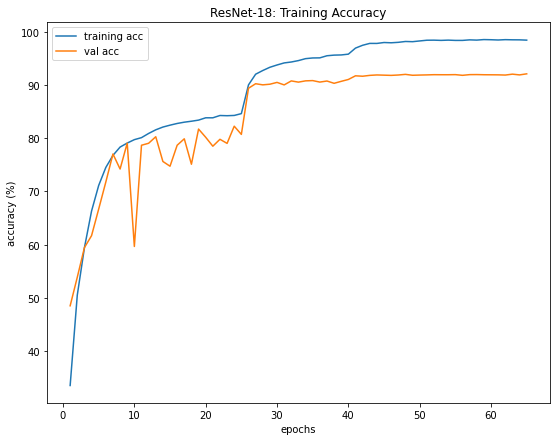

In [78]:
plt.figure(figsize = (9, 7))
plt.plot(list(training_history_lr_scheduler.keys()), [training_history_lr_scheduler[k]['acc'] for k in training_history_lr_scheduler.keys()], label = 'training acc')
plt.plot(list(training_history_lr_scheduler.keys()), [training_history_lr_scheduler[k]['val_acc'] for k in training_history_lr_scheduler.keys()], label = 'val acc')
plt.title("ResNet-18: Training Accuracy")
plt.xlabel("epochs")
plt.ylabel("accuracy (%)")
plt.legend(loc = 'best')
plt.show()

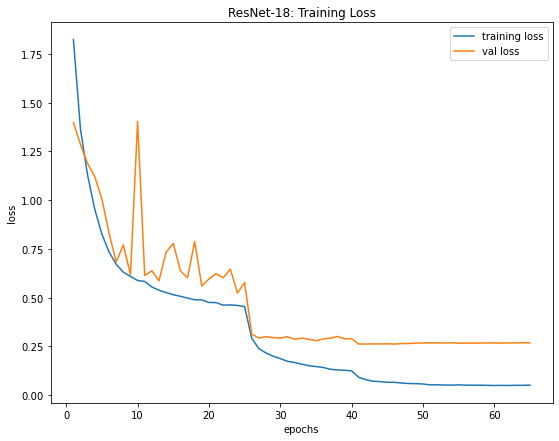

In [79]:
plt.figure(figsize = (9, 7))
plt.plot(list(training_history_lr_scheduler.keys()), [training_history_lr_scheduler[k]['loss'] for k in training_history_lr_scheduler.keys()], label = 'training loss')
plt.plot(list(training_history_lr_scheduler.keys()), [training_history_lr_scheduler[k]['val_loss'] for k in training_history_lr_scheduler.keys()], label = 'val loss')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend(loc = 'best')
plt.title("ResNet-18: Training Loss")
plt.show()

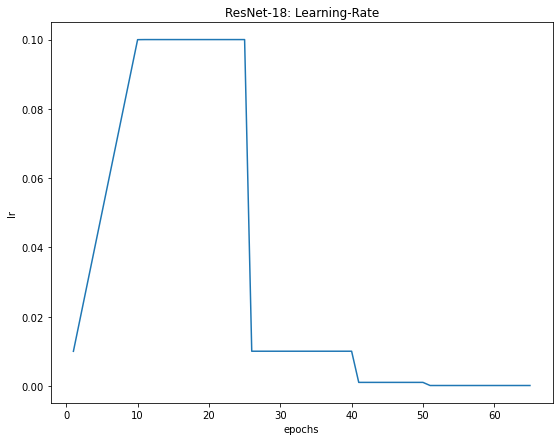

In [80]:
plt.figure(figsize = (9, 7))
plt.plot(list(training_history_lr_scheduler.keys()), [training_history_lr_scheduler[k]['lr'] for k in training_history_lr_scheduler.keys()])
plt.xlabel("epochs")
plt.ylabel("lr")
plt.title("ResNet-18: Learning-Rate")
plt.show()